# Implementing LiDAR-NeRF with Ray Drop

In [3]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 20*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh


from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-03-25 14:40:43.553332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 14:40:43.646828: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 14:40:43.998964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-25 14:40:43.999018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-25 14:40:45.084791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 14:40:45.086145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 14:40:45.086472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 14:40:45.086732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


## Load Gazebo Point Clouds and Convert to image-like data format

84.81983003899697 64 64
(12, 7)


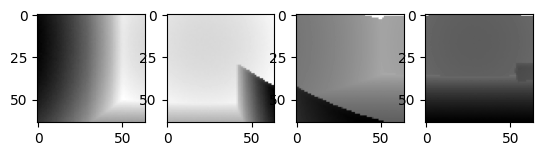

In [76]:
n_images =  10 #18 max for town, 11 max for old box, 16 for new box
n_rots = 7 #7 #1 #number of side by side frames to add in
# n_rots = 260 #130 for 1/16th #60 for 1/8th (needs to be much bigger when we are splitting up range images vertically)

#Get LiDAR Intrinsics
#Simulated LIDAR Sensor -- (look for <min_angle> in velodyne.world file in ROS package)
phimin = -0.53529248 #rad
phimax = 0.18622663 #rad
#achieve roughly same horizonal and vertical fov
vert_fov = np.rad2deg(phimax-phimin)
# images = np.zeros([n_images, 64, image_width, 1])
images = np.zeros([n_images*n_rots, 64, 64, 1]) #squares
# images = np.zeros([n_images*n_rots, 64, 2, 1]) #2 pixels wide
poses = np.zeros([n_images*n_rots,4,4])

#focal length (in pixels) = Image Size / (2 tan(FOV/2)) #needs to be array!
focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #default image size
H, W = images.shape[1:3]
print(focal, H, W)

# gtfn = "gazebo_scene/ground_truth.npy" #town
# gtfn = "gazebo_scene2/ground_truth.npy" #box v1
# gtfn = "gazebo_scene2/box_ground_truth.npy" #box v2
gtfn = "gazebo_scene2/box2_ground_truth.npy" #box v3
sensor_pose = np.load(gtfn)
# print(sensor_pose)
print(np.shape(sensor_pose))

for i in range(n_images):
#     for j in range(n_rots):
    #load point cloud file
#     pcfn = "gazebo_scene/scan" + str(i+2) + ".npy" #town
#         pcfn = "gazebo_scene2/scan" + str(i+2) + ".npy" #box v1
#         pcfn = "gazebo_scene2/box_scan" + str(i+2) + ".npy" #box v2
    pcfn = "gazebo_scene2/box2_scan" + str(i+2) + ".npy" #box v3
    pc = np.load(pcfn)
    #cap inf values
    pc[pc[:,0]>64] = 32 #64 #0
    pc[pc[:,0]<-64] = 32 #64 #0

    #convert to image array
    pc_spherical = LC.c2s(LC,pc).numpy() #[r, theta, phi]

    for j in range(n_rots):

        pcs = np.reshape(pc_spherical, [-1,64,3])
        pcs = np.flip(pcs, axis = 1) #flip vertical
        pcs = np.flip(pcs, axis = 0) #flip horizontal to look at first clockwise patch of scan sweep 

        #resize image to 64x64
        image_width = int((vert_fov/360)*np.shape(pcs)[0])
        
        pcs = pcs[j*image_width:(j+1)*image_width,:,0].T ##square
#         pcs = pcs[(j*image_width//32):((j+1)*image_width//32),:,0].T #32nds

        pcs = cv2.resize(pcs, (64, 64), cv2.INTER_NEAREST) #keep square
        #preserve aspect ratio and focal length but just take middle
#         pcs = pcs[:,31:33] #uncomment for 32nds
        images[j+(i*n_rots),:,:,0] = pcs

        #get sensor transformation matrix
        rotm = np.eye(4)
        rotm[0,3] = sensor_pose[i+1,0] #x
        rotm[2,3] = -sensor_pose[i+1,1] #y
        rotm[1,3] = -sensor_pose[i+1,2] #z
        rotm[:3,:3] = R.from_quat(sensor_pose[i+1,3:]).as_matrix() 
        
        #account for image crop in rotation
        crop_angle = -(phimax-phimin)/2 - j*(phimax-phimin) #square
#         crop_angle = -(phimax-phimin)/64 - j*(phimax-phimin)/32 #2-pixels wide
        rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() #test
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm

        #flip x and z axis
        rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

        # flip sign of y and z axis
        rotm[0:3,2] *= -1 
        rotm[0:3,1] *= -1
        rotm = rotm[[1,0,2,3],:]
        rotm[2,:] *= -1 # flip whole world upside down
#         #translate all frames above xy plane
#         rotm[2,-1] += 25 #for town  
#         rotm[2,-1] += 5 #for box (old)
        rotm[2,-1] += 7 #for box (new)

# #         scale translations
#         rotm[:3,-1] *= 0.1
#         #scale ranges measurements?
#         images[j+(i*n_rots),:,:,0] *= 0.1
        
        poses[j+(i*n_rots)] = rotm

fig, ax = p.subplots(1,4)
ax[0].imshow(images[-4,:,:,0], cmap = "gray", norm='log')
ax[1].imshow(images[-3,:,:,0], cmap = "gray", norm='log')
ax[2].imshow(images[-2,:,:,0], cmap = "gray", norm='log')
ax[3].imshow(images[-1,:,:,0], cmap = "gray", norm='log')
images = images.astype(np.float32)
poses = poses.astype(np.float32)

# test on one only
testimg, testpose = images[(n_images*n_rots)-1], poses[(n_images*n_rots)-1]
images = images[:((n_images*n_rots)-1),...,:3]
poses = poses[:((n_images*n_rots)-1)]

# #90/10 split
# cutoff = (n_images*9)//10
# print(cutoff)
# testimg, testpose = images[cutoff:], poses[cutoff:]
# images = images[:cutoff,...,:3]
# poses = poses[:cutoff]

##  Train Vanilla NeRF on depth image data

In [77]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6 #6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256): #8,256
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
#     outputs = dense(4, act=None)(outputs)
#     outputs = dense(2, act=None)(outputs) #"rgb" (single channel) + depth map
    outputs = dense(1, act=None)(outputs) #test

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
#     print("dirs:", np.shape(dirs))
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
#     print(rays_d)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d


def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=True):

    def batchify(fn, chunk=1024*256): #1024*128 converged for box3 #1024*32 in TinyNeRF
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    #[image_height, image_width, batch_size, 3]
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    print(np.shape(pts_flat.numpy()))
    pts_flat = embed_fn(pts_flat)
    print(np.shape(pts_flat.numpy()))
    raw = batchify(network_fn)(pts_flat)
#     raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
#     raw = tf.reshape(raw, list(pts.shape[:-1]) + [2]) #two channel (old)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [1]) #depth only (new)

#     print(tf.shape(raw))
    
    # Compute opacities and colors
    #was this
#     sigma_a = tf.nn.relu(raw[...,3])
#     rgb = tf.math.sigmoid(raw[...,:3]) 
#     sigma_a = tf.nn.relu(raw[...,1]) #for depth only (old?)
#     rgb = tf.math.sigmoid(raw[...,0])[:,:,:,None] 
    sigma_a = tf.nn.relu(raw[...,0]) #test only looking at sigma
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
#     rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    rgb_map = tf.reduce_sum(weights * z_vals, -1) #test
    acc_map = tf.reduce_sum(weights, -1)

#     return rgb_map, depth_map, acc_map
    return depth_map, acc_map

(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)


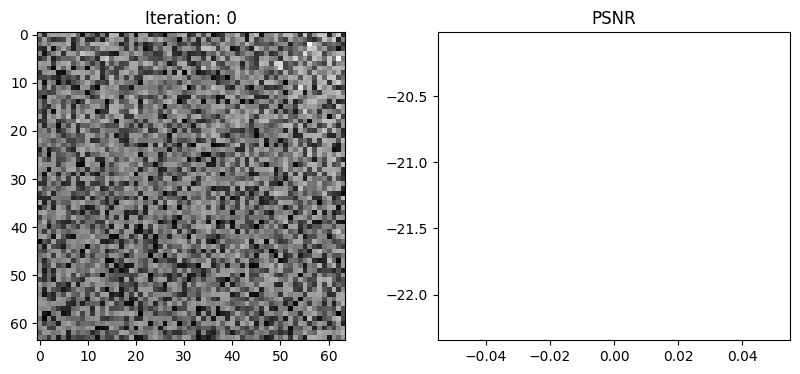

(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)


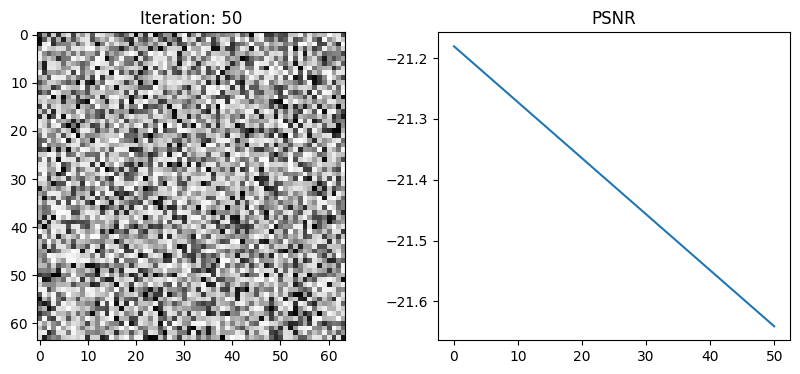

(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)


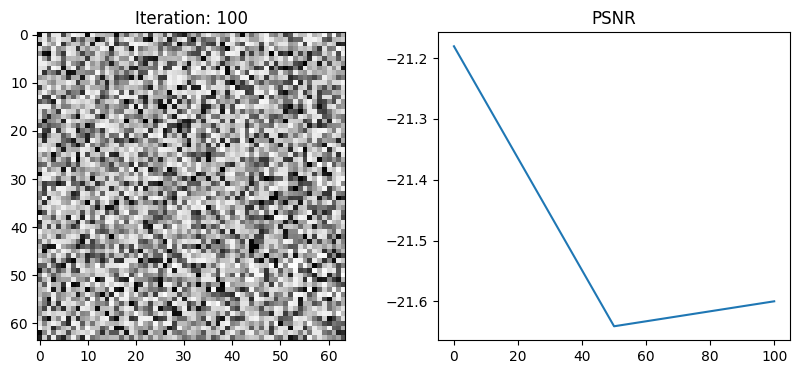

(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)
(65536, 39)
(65536, 3)


KeyboardInterrupt: 

In [78]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
# optimizer = tf.keras.optimizers.Adam(5e-5)

N_samples = 16 #64 #decrease as needed for VRAM
N_iters = 50_000
psnrs = []
iternums = []
i_plot = 50

import time
t = time.time()
for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    #get ray origins and ray directions
    rays_o, rays_d = get_rays(H, W, focal, pose)
    
    with tf.GradientTape() as tape:
        #just calculate loss via comparing depth output vs target (should also be depth!)
        depth, acc = render_rays(model, rays_o, rays_d, near=1., far=64., N_samples=N_samples, rand=True)
        depth = depth[:,:,None]
        
#         print(tf.shape(rays_o), tf.shape(rays_d))

        #default loss from TinyNERF
#         loss = tf.reduce_mean(tf.square(depth - target)) 
        #Distance Loss only
#         loss = tf.reduce_mean(tf.abs(depth - target)) # <-- works way better than dist^2
    
        #LiDAR-NeRF LoSS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        ## L_total = L_dist + lam1*L_intensity + lam2*L_raydrop + lam3*L_reg
        ##          lam1=1, lam2=1, lam3=100
        ## L_reg --> structural regularization: consider gradient loss only on high-texture areas
        
        ## Calculate Gradient Loss 
        thresh = 0.025
        mask = np.zeros(np.shape(target[:,:,0]))

        vertical_grad_target = np.gradient(target[:,:,0])[0] 
        vertical_past_thresh = np.argwhere(tf.abs(vertical_grad_target) > thresh)
        mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 1
        
        horizontal_grad_target = np.gradient(target[:,:,0])[1]
        horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target) > thresh)
        mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 1

        vertical_grad_inference = np.gradient(depth[:,:,0])[0]
        horizontal_grad_inference = np.gradient(depth[:,:,0])[1]
  
        mag_difference = tf.math.sqrt((vertical_grad_target-vertical_grad_inference)**2 + (horizontal_grad_target-horizontal_grad_inference)**2)
        L_reg = tf.reduce_mean(np.multiply(mag_difference, mask))
#         L_reg = tf.reduce_mean(tf.abs(np.multiply(vertical_grad_target-vertical_grad_inference, mask)))
        L_reg = tf.cast(L_reg, tf.float32)        
        L_dist = tf.reduce_mean(tf.abs(depth - target))
        
        lam1 = 100
        loss = L_dist + lam1*L_reg
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        t = time.time()
        sampl = int(np.random.uniform(low=0, high=len(testpose)-1))        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose) #constant validation image
#         rays_o, rays_d = get_rays(H, W, focal, testpose[sampl]) #90/10 split
        depth, acc = render_rays(model, rays_o, rays_d, near=1., far=64., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(depth[:,:,None] - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(121)
        p.imshow(depth,cmap = "gray", norm='log')
#         p.set_aspect(2) #test
        p.title(f'Iteration: {i}')
        p.subplot(122)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        p.show()
print('Done')

In [186]:
i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
#pinhole camera projection
# dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1) 
#test-- reformat for LiDAR depth measurements
vert_fov = np.rad2deg(phimax-phimin)
# print(focal)
print(vert_fov)
dirs = tf.stack([(i-(W*.5))/focal, -(j-(H*.5))/focal, -tf.ones_like(i)], -1) #pinhole camera projection


# c2w = poses[0]
c2w = np.eye(3)
c2w = tf.cast(c2w, tf.float32)
rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
# print(N_samples)

near = 0.
far = 64.
z_vals = tf.linspace(near, far, N_samples) 
z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
#[image_height, image_width, batch_size, 3]
pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
pts_flat = tf.reshape(pts, [-1,3])

41.33999984103539


In [187]:
# print(i)
# print(np.arcsin((i-(W*.5))/focal))
# print(dirs)
print(np.shape(dirs))
# print(np.shape(pts))

#try remaking <dirs> but with spherical projection (not pinhole camera intrinsics)
i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
print(np.shape(i))

#pinhole camera projection
#test-- reformat for LiDAR depth measurements
vert_fov = np.rad2deg(phimax-phimin)
#pinhole camera projection
dirs = tf.stack([(i-(W*.5))/focal, -(j-(H*.5))/focal, -tf.ones_like(i)], -1) 
#"square" lidar image
dirs_test = tf.stack([-tf.ones_like(i), (i-(W*.5))/focal, np.pi/2-(j-(H*.5))/focal], -1) 
#"croped" lidar image
# dirs_test = tf.stack([-tf.ones_like(i), (i-(W*.5))/focal, np.pi/2-(j-(H*.5))/focal - - np.rad2deg(phimax-phimin)], -1) 


dirs_test = tf.reshape(dirs_test,[-1,3])

test = LC.s2c(LC, dirs_test)
# test = test*64
# print(test)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
disp.append(Points(test, c = 'red'))
# disp.append(Points(pts_flat, c = 'blue'))
disp.append(Points(tf.reshape(rays_d, [-1,3]), c = 'blue'))
plt.show(disp, "test points_d")
ViewInteractiveWidget(plt.window)

(64, 64, 3)
(64, 64)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1920)

## Draw Full Point Cloud From Novel Frame

In [ ]:
num_rots = 279 #140 #70 for 1/8th

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

for j in range(num_rots):
# for j in np.linspace(0,7,15):
    #get sensor transformation matrix
    rotm = np.eye(4)
    # rotm[0,3] = sensor_pose[i+1,0] #x
    # rotm[2,3] = -sensor_pose[i+1,1] #y
    # rotm[1,3] = -sensor_pose[i+1,2] #z
    # rotm[:3,:3] = R.from_quat(sensor_pose[i+1,3:]).as_matrix() 

    # account for image crop in rotation -------------------
#     crop_angle = -(phimax-phimin)/2 - j*(phimax-phimin)#square
#     crop_angle = -(phimax-phimin)/16 - j*(phimax-phimin)/8 #eighth
#     crop_angle = -(phimax-phimin)/32 - j*(phimax-phimin)/16 #1/16
    crop_angle = -(phimax-phimin)/32 - j*(phimax-phimin)/32 #1/32
    rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

    #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
    sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() #test
    rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
    # ------------------------------------------------------

    # flip x and z axis
    rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

    rotm[0:3,2] *= -1 # flip sign of y and z axis
    rotm[0:3,1] *= -1
    rotm = rotm[[1,0,2,3],:]
    rotm[2,:] *= -1 # flip whole world upside down
    rotm[2,-1] += 7 #for box #translate all frames above xy plane
    #bring x and y to correct range
    rotm[0,-1] = -1.5
    rotm[1,-1] = 2 #3
    rotm = rotm.astype(np.float32)
    
    start = time.time()
    
    #call NeRF using specified novel rotm
    rays_o, rays_d = get_rays(H, W, focal, rotm)
    depth, acc = render_rays(model, rays_o, rays_d, near=1., far=64., N_samples=N_samples)
    end = time.time()
#     print("inference took:", end-start)
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed

    phimin = -0.53529248 #rad
    phimax = 0.18622663 #rad

    count = 0
    for w in range(np.shape(pcs)[1]):
        for h in range(np.shape(pcs)[0]):
            new_point_cloud_spherical[count,0] = depth[w,h] #radius
#             new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/(np.shape(depth)[0])) #theta (square)
#             new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/(np.shape(depth)[0]))/8 #theta (eighth)
#             new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/(np.shape(depth)[0]))/16 #theta (1/16)
            new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/(np.shape(depth)[0]))/32 #theta (1/32)
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
            count+= 1

    #account for sweep angle using j
#     new_point_cloud_spherical[:,1] -= j*(phimax-phimin) #square
#     new_point_cloud_spherical[:,1] -= j*(phimax-phimin)/8 #eighth
#     new_point_cloud_spherical[:,1] -= j*(phimax-phimin)/16 #1/16
    new_point_cloud_spherical[:,1] -= j*(phimax-phimin)/32 #1/32
            
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

    # rainbow by z height
    zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
    cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
    disp.append(Points(new_point_cloud_cart, c = cname, r = 3, alpha = 0.5))

plt.show(disp, "Novel Point Cloud From NeRF")
ViewInteractiveWidget(plt.window)

In [14]:
# model.save_weights("models/town.ckpt")
# model.load_weights("models/town.ckpt")
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 39)]         0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 256)          10240       ['input_3[0][0]']                
                                                                                                  
 dense_19 (Dense)               (None, 256)          65792       ['dense_18[0][0]']               
                                                                                                  
 dense_20 (Dense)               (None, 256)          65792       ['dense_19[0][0]']               
                                                                                            